<a href="https://colab.research.google.com/github/SJinLee/XAI2023/blob/main/k6.data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip drive/MyDrive/xai/car_or_truck.zip

In [ ]:
!unzip drive/MyDrive/xai/base_models.zip

In [ ]:
# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
# these are a new feature in TF 2.2
from tensorflow.keras.layers.experimental import preprocessing


pretrained_base = tf.keras.models.load_model(
    'cv-course-models/vgg16-pretrained-base',
)
pretrained_base.trainable = False

model = keras.Sequential([
    # Preprocessing
    preprocessing.RandomFlip('horizontal'), # flip left-to-right
    preprocessing.RandomContrast(0.5), # contrast change by up to 50%
    # Base
    pretrained_base,
    # Head
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=30,
    verbose=1,
)

Epoch 1/30
80/80 [==============================] - 19s 212ms/step - loss: 0.5230 - binary_accuracy: 0.7415 - val_loss: 0.4131 - val_binary_accuracy: 0.8285
Epoch 2/30
80/80 [==============================] - 13s 158ms/step - loss: 0.4080 - binary_accuracy: 0.8204 - val_loss: 0.3701 - val_binary_accuracy: 0.8476
Epoch 3/30
80/80 [==============================] - 13s 162ms/step - loss: 0.3699 - binary_accuracy: 0.8392 - val_loss: 0.3491 - val_binary_accuracy: 0.8505
Epoch 4/30
80/80 [==============================] - 13s 161ms/step - loss: 0.3434 - binary_accuracy: 0.8564 - val_loss: 0.3337 - val_binary_accuracy: 0.8606
Epoch 5/30
80/80 [==============================] - 17s 211ms/step - loss: 0.3270 - binary_accuracy: 0.8655 - val_loss: 0.3241 - val_binary_accuracy: 0.8634
Epoch 6/30
80/80 [==============================] - 12s 156ms/step - loss: 0.3018 - binary_accuracy: 0.8788 - val_loss: 0.3166 - val_binary_accuracy: 0.8676
Epoch 7/30
80/80 [==============================] - 12s 15

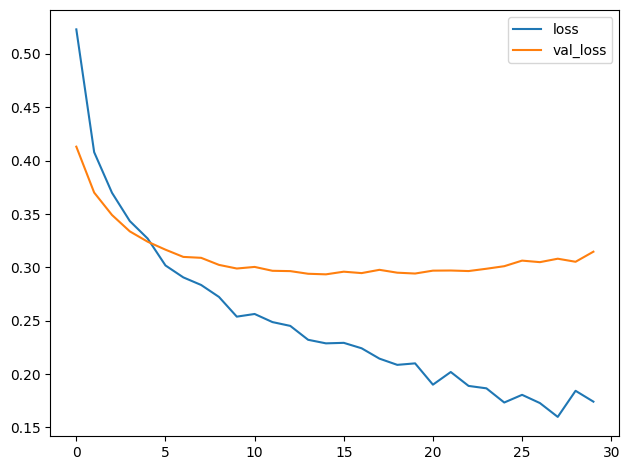

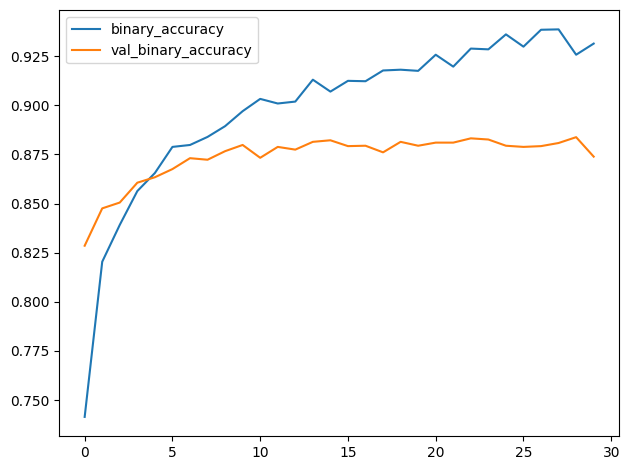

In [ ]:
import pandas as pd

history_frame = pd.DataFrame(history.history)

history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();